In [1]:
#%matplotlib inline
%matplotlib widget

In [2]:
# initialization
from rayoptics.environment import *
from rayoptics.gui.appcmds import refocus
from rayoptics.oprops import doe

# Create a new model

In [3]:
opm = OpticalModel()
sm  = opm['seq_model']
osp = opm['optical_spec']
pm = opm['parax_model']
em = opm['ele_model']
pt = opm['part_tree']
ar = opm['analysis_results']

In [4]:
print(f"{opm.ro_version=}")
listobj(opm['system_spec'])

opm.ro_version='0.9.5.post1.dev3+gfa56c0e.d20241222'
SystemSpec:
opt_model: <rayoptics.optical.opticalmodel.OpticalModel object at 0x14b29a600>
title: 
initials: 
_dimensions: mm
temperature: 20.0
pressure: 760.0



## Define first order aperture and field for system

In [5]:
osp.pupil = PupilSpec(osp, key=['object', 'epd'], value=5.0)
osp.field_of_view = FieldSpec(osp, key=['object', 'height'], flds=[0., 1.0])
osp.spectral_region = WvlSpec([(486.1327, 0.5), (587.5618, 1.0), (656.2725, 0.5)], ref_wl=1)

## Define interface and gap data for the sequential model

In [6]:
opm.radius_mode = False

sm.gaps[0].thi=1.0e10

sm.add_surface([1/27.36, 1.0, 'N-BK7', 'Schott'])
#sm.add_surface([0.0387, 1.0, 'N-BK7', 'Schott'])
s1 = sm.ifcs[sm.cur_surface]

sm.add_surface([0, 49.])
s2 = sm.ifcs[sm.cur_surface]
g2 = sm.gaps[sm.cur_surface]

## Update the model

In [7]:
opm.update_model()

In [8]:
sm.list_model()

              c            t        medium     mode   zdr      sd
  Obj:     0.000000  1.00000e+10       air             1      1.0000
    1:     0.036550      1.00000     N-BK7             1      2.5000
    2:     0.000000      49.0000       air             1      2.4723
  Img:     0.000000      0.00000                       1     0.14945


In [9]:
sm.gaps[1].medium.glass_code()

'517.642'

In [10]:
sm.rndx[1::1]

[[np.float64(1.5223762897312285),
  np.float64(1.5168000345005885),
  np.float64(1.5143223472613747)],
 [1.0, 1.0, 1.0]]

In [11]:
pupil = [0., 1.]
fi = 0
wl = osp.spectral_region.reference_wvl
fld, wvl, foc = osp.lookup_fld_wvl_focus(fi, wl)
ray_result = trace_ray(opm, pupil, fld, wvl)
ray, ray_op, wvl = ray_result.pkg
list_ray(ray)

            X            Y            Z           L            M            N               Len
  0:      0.00000      0.00000            0     0.000000     0.000000     1.000000        1e+10
  1:      0.00000      2.50000      0.11446     0.000000    -0.031219     0.999513      0.88597
  2:      0.00000      2.47234            0     0.000000    -0.047353     0.998878       49.055
  3:      0.00000      0.14945            0     0.000000    -0.047353     0.998878            0


In [12]:
refocus(opm)
listobj(osp['focus'])
g2.thi

focus shift=3.152551988012263



49.0

In [13]:
opm.update_model()

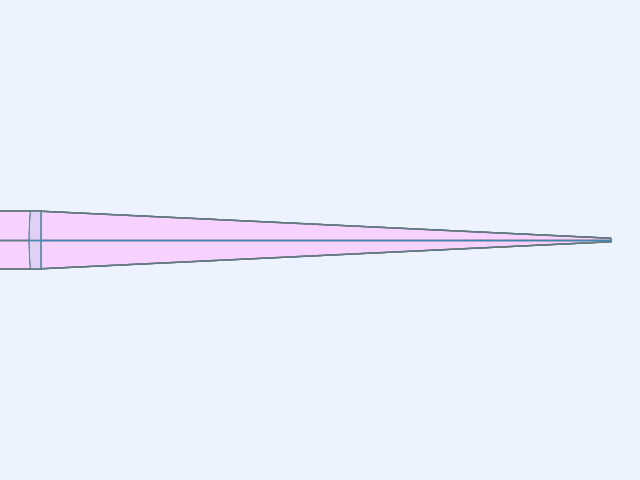

In [15]:
layout_plt = plt.figure(FigureClass=InteractiveLayout, opt_model=opm,
                        do_draw_rays=True, do_paraxial_layout=False).plot()

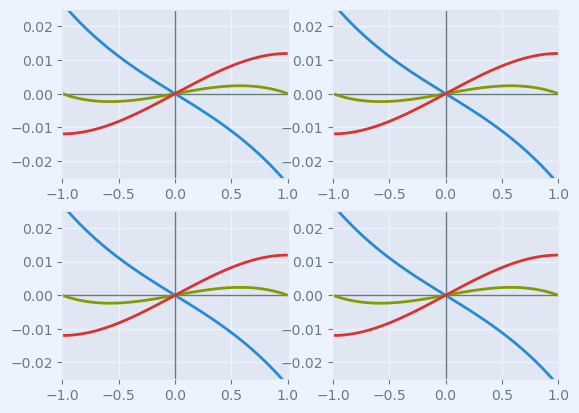

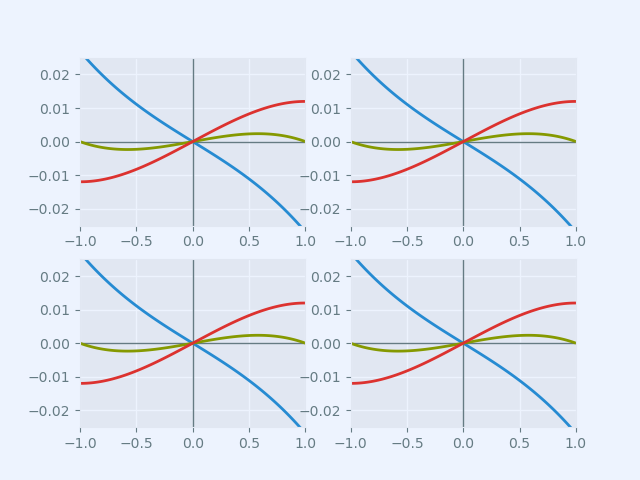

In [16]:
plt.figure(FigureClass=RayFanFigure, opt_model=opm, data_type='Ray', scale_type=Fit.User_Scale,
                 user_scale_value=0.025).plot()

## Compute hybrid achromat

In [17]:
V_doe = get_wavelength('d')/(get_wavelength('F') - get_wavelength('C'))
medium1 = sm.gaps[1].medium
nd = medium1.rindex(get_wavelength('d'))
nC = medium1.rindex(get_wavelength('C'))
nF = medium1.rindex(get_wavelength('F'))
V_lens = (nd - 1)/(nF - nC)
f = 50.
phi_sys = 1/f
phi_doe, phi_lens = elements.achromat(phi_sys, V_doe, V_lens)
doe_quadratic_phase = -phi_doe/2
print(f"{f=}\n{V_doe=:8.4f}, {V_lens=:8.4f}\n{phi_doe=:8.5f}, {phi_lens=:8.5f}")

f=50.0
V_doe= -3.4534, V_lens= 64.1673
phi_doe= 0.00102, phi_lens= 0.01898


In [18]:
(phi_doe+phi_lens)

np.float64(0.02)

In [19]:
c = phi_lens/(nd - 1);c

np.float64(0.03672328637229341)

In [20]:
idx_doe = 2
sm.ifcs[idx_doe].phase_element = doe.DiffractiveElement(ref_wl=get_wavelength('d'),
                                                        coefficients=[doe_quadratic_phase],
                                                        phase_fct=doe.radial_phase_fct)
s1.profile.cv = phi_lens/(nd - 1)
g2.thi = 49.

In [21]:
opm.update_model()

In [22]:
sm.list_model()

              c            t        medium     mode   zdr      sd
  Obj:     0.000000  1.00000e+10       air             1      1.0000
    1:     0.036723      1.00000     N-BK7             1      2.5000
    2:     0.000000      49.0000       air             1      2.4722
  Img:     0.000000      0.00000                       1    0.014040


In [23]:
listobj(sm)

0: Obj: dummy
profile: Spherical
c=0.0,   r=0.0
surface_od=1.0
t=10000000000.0 (+1);    medium: air

1: transmit
profile: Spherical
c=0.03672328637229341,   r=27.230678372904805
surface_od=2.500000000040251
t=1.0 (+1);    medium: N-BK7, Schott

2: transmit
profile: Spherical
c=0,   r=0.0
doe: radial_phase_fct
coefficients: [np.float64(-0.0005107021679118856)]
ref wl: 587.5618nm  order: 1
surface_od=2.4722257978475954
t=49.0 (+1);    medium: air

3: Img: dummy
profile: Spherical
c=0.0,   r=0.0
surface_od=0.014040168828051612

do apertures: True


In [24]:
ray_result = trace_ray(opm, pupil, fld, wvl)
ray, ray_op, wvl = ray_result.pkg
list_ray(ray)

            X            Y            Z           L            M            N               Len
  0:      0.00000      0.00000            0     0.000000     0.000000     1.000000        1e+10
  1:      0.00000      2.50000        0.115     0.000000    -0.031368     0.999508      0.88543
  2:      0.00000      2.47223            0     0.000000    -0.050104     0.998744       49.062
  3:      0.00000      0.01404            0     0.000000    -0.050104     0.998744            0


In [25]:
refocus(opm)
listobj(osp['focus'])
print(f"{g2.thi=}")

focus shift=0.2798682166476073

g2.thi=49.0


In [26]:
opm.update_model()

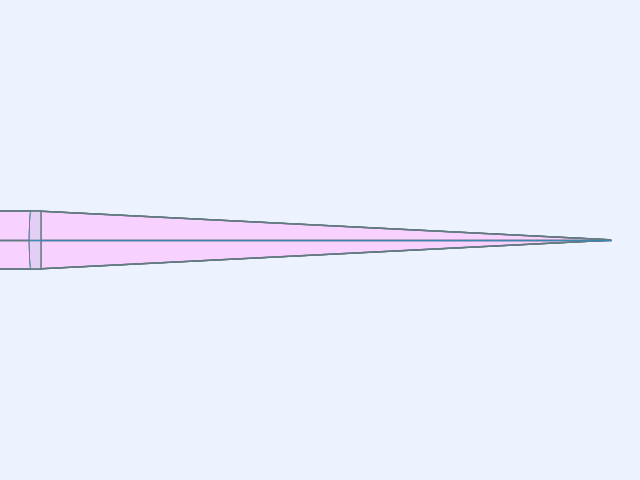

In [27]:
layout_plt2 = plt.figure(FigureClass=InteractiveLayout, opt_model=opm, do_draw_rays=True, do_paraxial_layout=False).plot()

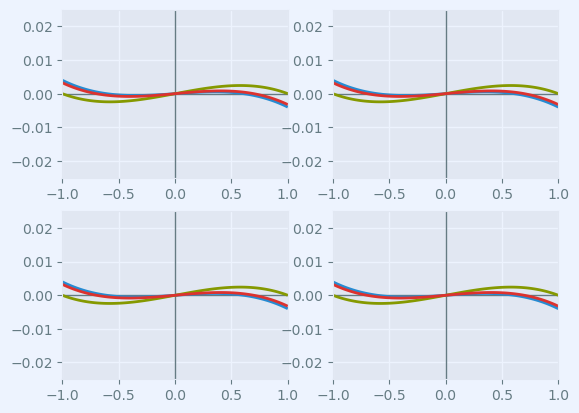

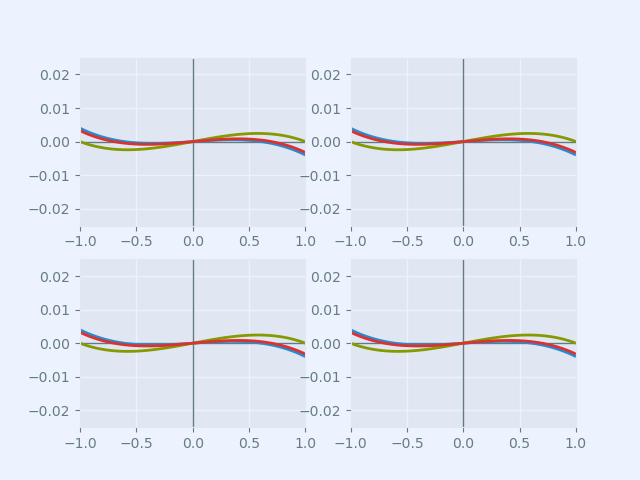

In [28]:
plt.figure(FigureClass=RayFanFigure, opt_model=opm, data_type='Ray', scale_type=Fit.User_Scale,
                 user_scale_value=0.025).plot()

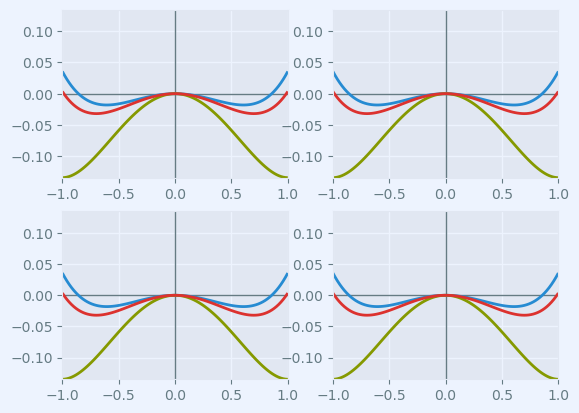

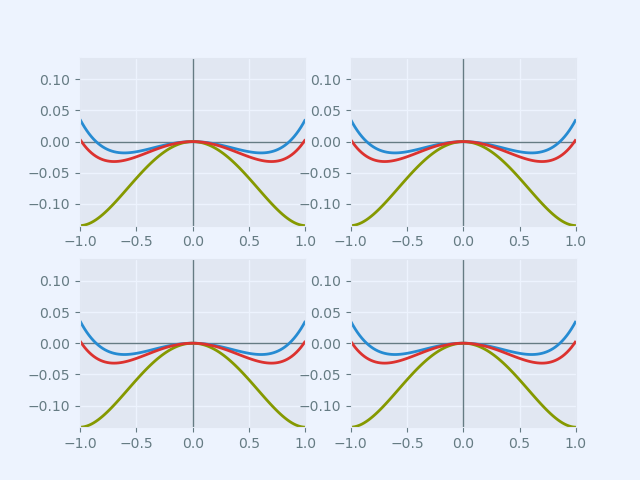

In [29]:
plt.figure(FigureClass=RayFanFigure, opt_model=opm, data_type='OPD', scale_type=Fit.All_Same).plot()

## examine DOE phase calculation

In [30]:
pupil = [0., 1.]
fi = 0
wl = osp.spectral_region.reference_wvl
fld, wvl, foc = osp.lookup_fld_wvl_focus(fi, wl)
ray_d, ray_op_d, wvl_d, opd_d = trace_with_opd(opm, pupil, fld, get_wavelength('d'), foc)
ray_C, ray_op_C, wvl_C, opd_C = trace_with_opd(opm, pupil, fld, get_wavelength('C'), foc)
ray_F, ray_op_F, wvl_F, opd_F = trace_with_opd(opm, pupil, fld, get_wavelength('F'), foc)

In [31]:
z_dir = sm.z_dir[idx_doe]

d_idx = osp.spectral_region.wavelengths.index(get_wavelength('d'))
n_in_d = sm.rndx[d_idx][0]
n_out_d = sm.rndx[d_idx][1]
ifc_cntxt = z_dir, wvl_d, n_in_d, n_out_d, sm.ifcs[idx_doe].interact_mode
_, dW_d = rt.phase(sm.ifcs[idx_doe], ray_d[idx_doe][0], ray_d[idx_doe-1][1], ray_d[idx_doe][3], ifc_cntxt)

C_idx = osp.spectral_region.wavelengths.index(get_wavelength('C'))
n_in_C = sm.rndx[C_idx][0]
n_out_C = sm.rndx[C_idx][1]
ifc_cntxt = z_dir, wvl_C, n_in_C, n_out_C, sm.ifcs[idx_doe].interact_mode
_, dW_C = rt.phase(sm.ifcs[idx_doe], ray_C[idx_doe][0], ray_C[idx_doe-1][1], ray_C[idx_doe][3], ifc_cntxt)

F_idx = osp.spectral_region.wavelengths.index(get_wavelength('F'))
n_in_F = sm.rndx[F_idx][0]
n_out_F = sm.rndx[F_idx][1]
ifc_cntxt = z_dir, wvl_F, n_in_F, n_out_F, sm.ifcs[idx_doe].interact_mode
_, dW_F = rt.phase(sm.ifcs[idx_doe], ray_F[idx_doe][0], ray_F[idx_doe-1][1], ray_F[idx_doe][3], ifc_cntxt)

In [32]:
print(f"{dW_d=:11.5g}\n{dW_C=:11.5g}\n{dW_F=:11.5g}")

dW_d= -0.0031214
dW_C= -0.0034866
dW_F= -0.0025821


In [33]:
opd_d, opd_C, opd_F
print(f"{opd_d=:11.5g}\n{opd_C=:11.5g}\n{opd_F=:11.5g}")

opd_d=-7.9095e-05
opd_C= 2.0681e-06
opd_F=  2.094e-05


In [34]:
ray_op_d, ray_op_C, ray_op_F
print(f"{ray_op_d=:11.5g}\n{ray_op_C=:11.5g}\n{ray_op_F=:11.5g}")

ray_op_d=     1.3399
ray_op_C=     1.3373
ray_op_F=     1.3454


## save the model

In [35]:
opm.save_model('HybridAchromat')

## verify file can be restored and gives same results

In [36]:
notebook_pth = Path().resolve()

In [37]:
opm_res = open_model(notebook_pth/'HybridAchromat.roa')

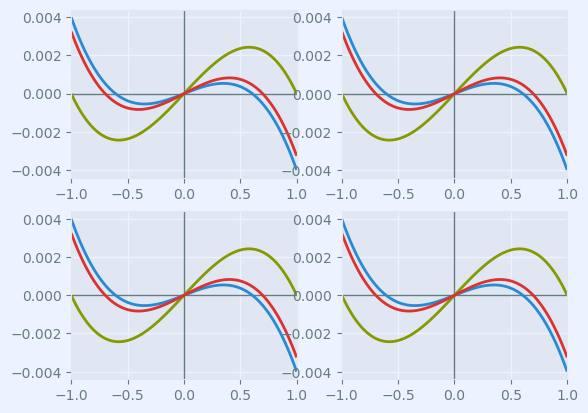

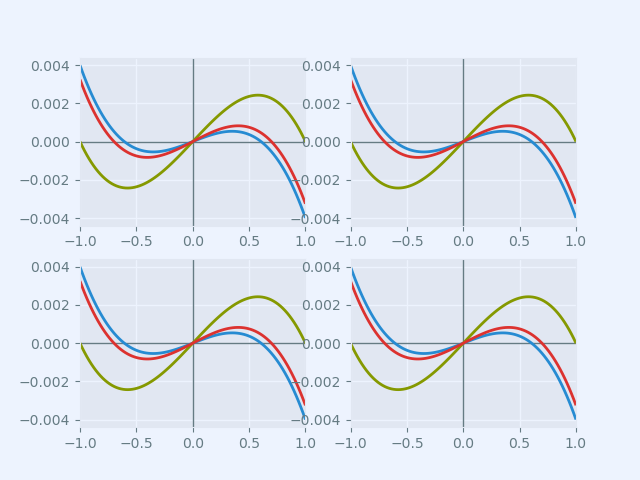

In [38]:
plt.figure(FigureClass=RayFanFigure, opt_model=opm_res, data_type='Ray').plot()

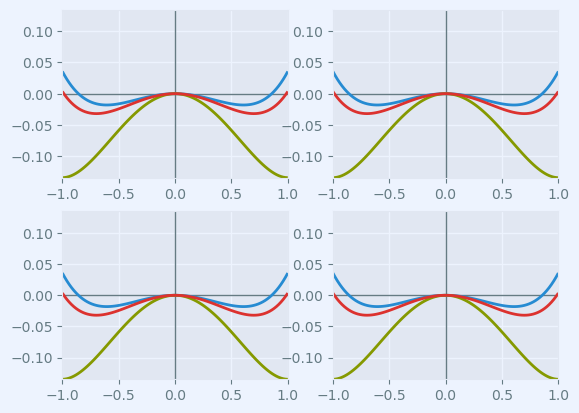

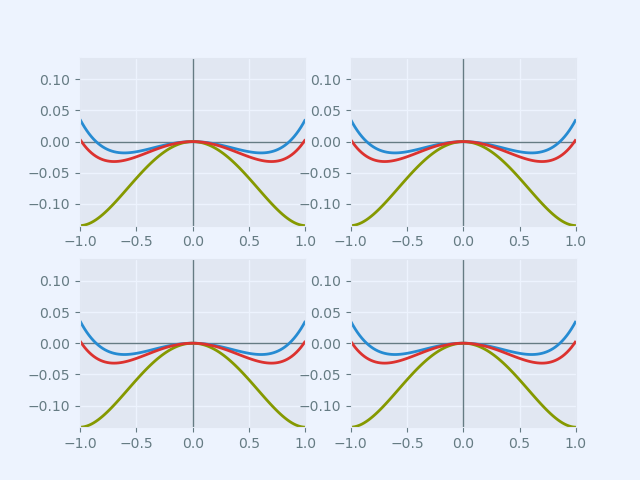

In [39]:
plt.figure(FigureClass=RayFanFigure, opt_model=opm_res, data_type='OPD', scale_type=Fit.All_Same).plot()